In [235]:
import warnings
from functools import partial
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from scipy.optimize import minimize
from scipy.special import softmax

warnings.simplefilter("ignore")


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


pd.set_option("display.max_columns", 100)


def kl_divergence(gts, preds, ds_weights=None, class_weights=None):
    if ds_weights is None:
        ds_weights = np.ones(len(preds)).astype(np.float64)
    if class_weights is None:
        class_weights = np.ones(6).astype(np.float64).reshape(1, -1)

    preds = softmax(preds, axis=1)
    score = gts * np.log(gts / preds)

    score = (score * class_weights).sum(axis=1) / class_weights.sum() * 6

    score = np.average(score, weights=ds_weights)

    return score


def loss_fn(weights, gts, preds, ds_weights, class_weights):
    final_preds = 0
    weights = np.array(weights) / np.sum(weights)
    for weight, pred in zip(weights, preds):
        final_preds += weight * pred
    score = kl_divergence(
        gts=gts, preds=final_preds, ds_weights=ds_weights, class_weights=class_weights
    )
    return score


def round_to_nearest(x, base=0.05):
    return base * np.round(x / base)

# gt

eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,num_votes,ds_weight
i64,f64,f64,f64,f64,f64,f64,f64,f64
1628180742,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2277392603,0.0,0.0,0.454545,0.0,0.090909,0.454545,11.0,1.0
722738444,0.0,0.0625,0.0,0.875,0.0,0.0625,16.0,1.0
387987538,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0
2175806584,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


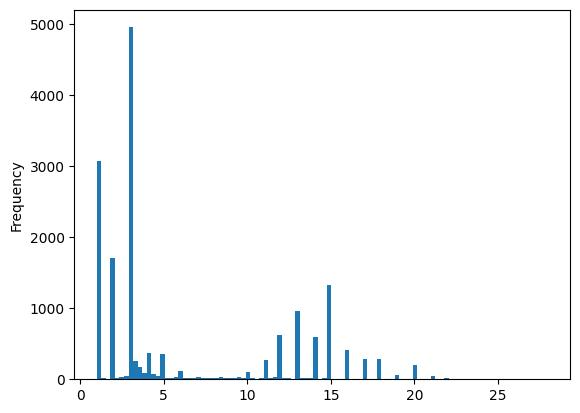

In [256]:
# 一旦 5939件
cols = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
df = pl.read_csv("/ml-docker/input/hms-harmful-brain-activity-classification/train.csv")
eps = 1e-10
lb, ub = 4, 9
lq_ratio = 0.0
agg_policy = "mean"
class_weights = np.array([1.33, 1.0, 1.0, 1.36, 1.38, 0.77])

votes = df.select(cols).to_numpy()
df = df.with_columns(
    pl.Series(votes.sum(axis=1)).alias("num_votes"),
)

if agg_policy == "weighted-mean":
    true_df = (
        df.group_by("eeg_id", maintain_order=True)
        .agg(
            *[pl.col(col).mul("num_votes").sum().alias(col) for col in cols],
            pl.col("num_votes").sum().alias("sum_num_votes_per_eeg"),
        )
        .with_columns(
            *[
                pl.col(col).truediv(pl.col("sum_num_votes_per_eeg")).alias(col)
                for col in cols
            ],
        )
    )
elif agg_policy == "mean":
    true_df = df.group_by("eeg_id", maintain_order=True).agg(
        *[pl.col(col).mean() for col in cols],
    )
elif agg_policy == "max":
    true_df = df.group_by("eeg_id", maintain_order=True).agg(
        *[pl.col(col).max() for col in cols],
    )
else:
    raise ValueError(f"Invalid aggregation policy: {agg_policy}")

# voteの正規化
votes = true_df.select(cols).to_numpy()
true_df = true_df.with_columns(
    pl.Series(votes.sum(axis=1)).alias("num_votes"),
).with_columns(pl.col(col).truediv("num_votes").alias(col) for col in cols)

true_df = true_df.with_columns(
    pl.when(pl.col("num_votes").ge(ub))
    .then(pl.lit(1 - lq_ratio))
    .otherwise(
        pl.when(pl.col("num_votes").ge(lb))
        .then(pl.lit(lq_ratio))
        .otherwise(pl.lit(0.0))
    )
    .alias("ds_weight")
)

gts = true_df.sort("eeg_id")[cols].to_numpy() + eps
clean_eeg_ids = true_df["eeg_id"].unique()
true_df["num_votes"].to_pandas().plot.hist(bins=100)
display(true_df.head())
plt.show()

# oof

In [251]:
# ariyasu
print("ariyasu:")
configs = [
    "finetune_hms_chris_fmax30_50sec_16ims_bandpass",
    "finetune_hms_chris_fmax30_30sec_8ims_bandpass",
    "finetune_hms_chris_fmax30_30sec_8ims_bandpass_spe_and_eeg",
    "finetune_hms_chris_fmax90_10sec_8ims_bandpass_spe_and_eeg",
]
true_cols = ["seizure", "lpd", "gpd", "lrda", "grda", "other"]
pred_cols = [f"pred_{c}" for c in true_cols]
preds = []
folds = range(5)
for config in configs:
    oof = pl.read_csv(
        f"/ml-docker/input/yujiariyasu/oof-by-kaggle-note/{config}.csv"
    ).sort("eeg_id")
    oof = oof.filter(pl.col("eeg_id").is_in(clean_eeg_ids)).sort("eeg_id")
    oof = oof.join(
        true_df.select("eeg_id", "ds_weight"), on="eeg_id", how="inner"
    ).sort("eeg_id")
    oof = oof.to_pandas()
    pr = oof[pred_cols].to_numpy()
    score = kl_divergence(gts, pr, ds_weights=oof.ds_weight.values, class_weights=class_weights)
    print(len(oof), config, round(score, 4))
    preds.append(pr)
oof[true_cols] = gts - 1e-10
print("-" * 100)

# tattaka
print("tattaka:")
cols = [
    "oof_logits_seizure_vote",
    "oof_logits_lpd_vote",
    "oof_logits_gpd_vote",
    "oof_logits_lrda_vote",
    "oof_logits_grda_vote",
    "oof_logits_other_vote",
]
exp_dirs = [
    #     "/kaggle/input/hms-weights-2/exp092/inception_next_tiny_384_el30_mixup_50ep",
    #     "/kaggle/input/hms-weights-2/exp092/tiny_vit_21m_384_el30_mixup_50ep",
    #     "/kaggle/input/hms-weights-2/exp094/caformer_s18_2_5d_256_el30_mixup_100ep",
    #     "/kaggle/input/hms-weights-2/exp094/resnetrs50_2_5d_192_el30_mixup_100ep",
    #     "/kaggle/input/hms-weights-2/exp094/swinv2_tiny_window16_2_5d_256_el30_mixup_100ep",
    "/ml-docker/input/tattaka/hms-weights-3/exp137/inception_next_tiny_384_el30_mixup_50ep",
    "/ml-docker/input/tattaka/hms-weights-3/exp137/tiny_vit_21m_384_el30_mixup_50ep",
    "/ml-docker/input/tattaka/hms-weights-3/exp138/caformer_s18_2_5d_256_el30_mixup_100ep",
    "/ml-docker/input/tattaka/hms-weights-3/exp138/resnetrs50_2_5d_192_el30_mixup_100ep",
    "/ml-docker/input/tattaka/hms-weights-3/exp138/swinv2_tiny_window16_2_5d_256_el30_mixup_100ep",
    #     "/kaggle/input/hms-weights-2/exp108/convnext_large_384_el40_mixup_50ep",
]
for exp_dir in exp_dirs:
    df = pd.read_csv(glob(f"{exp_dir}/**/result_df.csv", recursive=True)[0])
    df_hq = df[df.num_votes > 7].groupby("eeg_id").first().reset_index()
    df_lw = df[df.num_votes <= 7].groupby("eeg_id").first().reset_index()
    df_lw = df_lw[~df_lw.eeg_id.isin(df_hq.eeg_id)]
    df = pd.concat([df_hq, df_lw])
    c = exp_dir.split("/")[-1]
    df = df[df.eeg_id.isin(oof.eeg_id)].sort_values("eeg_id")
    pr = df[cols].values
    preds.append(pr)
    configs.append(c)
    score = kl_divergence(gts, pr, ds_weights=oof.ds_weight.values, class_weights=class_weights)
    print(c, round(score, 4))
print("-" * 100)

# bilzard
print("bilzard:")
cols = [
    "pl_seizure_vote",
    "pl_lpd_vote",
    "pl_gpd_vote",
    "pl_lrda_vote",
    "pl_grda_vote",
    "pl_other_vote",
]
for c in [
    "eeg022_16ep_sc03c",
    "v5_panns_12ep_sc03c",
    "v5_eeg_24ep_cutmix",
    "v5_spec_bg_8ep",
]:
    df = pd.read_parquet(
        f"/ml-docker/working/kaggle-hms-bilzard/data/pseudo_label/{c}/train_pseudo_label.pqt"
    ).sort_values("eeg_id")
    df = df[df.eeg_id.isin(oof.eeg_id)].sort_values("eeg_id")
    pr = df[cols].values
    oof[pred_cols] = pr
    score = kl_divergence(gts, pr, ds_weights=oof.ds_weight.values, class_weights=class_weights)
    preds.append(pr)
    configs.append(c)
    print(c, round(score, 4))

print("-" * 100)

ariyasu:
17089 finetune_hms_chris_fmax30_50sec_16ims_bandpass 0.222
17089 finetune_hms_chris_fmax30_30sec_8ims_bandpass 0.2227
17089 finetune_hms_chris_fmax30_30sec_8ims_bandpass_spe_and_eeg 0.2227
17089 finetune_hms_chris_fmax90_10sec_8ims_bandpass_spe_and_eeg 0.2407
----------------------------------------------------------------------------------------------------
tattaka:
inception_next_tiny_384_el30_mixup_50ep 0.2484
tiny_vit_21m_384_el30_mixup_50ep 0.2385
caformer_s18_2_5d_256_el30_mixup_100ep 0.236
resnetrs50_2_5d_192_el30_mixup_100ep 0.245
swinv2_tiny_window16_2_5d_256_el30_mixup_100ep 0.2405
----------------------------------------------------------------------------------------------------
bilzard:
eeg022_16ep_sc03c 0.2395
v5_panns_12ep_sc03c 0.2567
v5_eeg_24ep_cutmix 0.2297
v5_spec_bg_8ep 0.2498
----------------------------------------------------------------------------------------------------


# Nelder-Mead

In [252]:
starting_weights = [1 / len(preds)] * len(preds)
constraints = {"type": "eq", "fun": lambda w: 1 - sum(w)}
bounds = [(0, 1)] * (len(preds))
res = minimize(
    partial(
        loss_fn,
        gts=gts,
        preds=preds,
        ds_weights=oof["ds_weight"].to_numpy(),
        class_weights=class_weights,
    ),
    starting_weights,
    method="Nelder-Mead",
    bounds=bounds,
    constraints=constraints,
)

In [253]:
round(res["fun"], 4), res["x"]

(0.1945,
 array([2.10835739e-01, 1.31496669e-01, 1.53035252e-01, 1.01645015e-01,
        8.68520734e-06, 1.15585540e-01, 1.79002007e-01, 5.17650019e-07,
        2.65019040e-04, 8.24002523e-08, 0.00000000e+00, 2.68248144e-01,
        2.67346808e-05]))

In [254]:
opt = res["x"].copy()
opt_old = np.array(
    [
        0.24543949,
        0.13689485,
        0.16187137,
        0.10738459,
        0.02167115,
        0.15755226,
        0.19887966,
        0.01746818,
        0.02361924,
        0.13611772,
        0.06941763,
        0.2068315,
        0.00395194,
    ]
)

In [255]:
# print
model_weights = opt / np.sum(opt)
model_weights_old = opt_old / np.sum(opt_old)
print("weights:")
for w, c in zip(model_weights, configs):
    print(c, round(w, 4))

score = loss_fn(
    model_weights_old,
    gts,
    preds,
    oof["ds_weight"].to_numpy(),
    class_weights=class_weights,
)
print(f"best_score(old_weight): {round(score, 4)}")

score = loss_fn(
    model_weights, gts, preds, oof["ds_weight"].to_numpy(), class_weights=class_weights
)
print(f"best_score: {round(score, 4)}")

weights:
finetune_hms_chris_fmax30_50sec_16ims_bandpass 0.1817
finetune_hms_chris_fmax30_30sec_8ims_bandpass 0.1133
finetune_hms_chris_fmax30_30sec_8ims_bandpass_spe_and_eeg 0.1319
finetune_hms_chris_fmax90_10sec_8ims_bandpass_spe_and_eeg 0.0876
inception_next_tiny_384_el30_mixup_50ep 0.0
tiny_vit_21m_384_el30_mixup_50ep 0.0996
caformer_s18_2_5d_256_el30_mixup_100ep 0.1543
resnetrs50_2_5d_192_el30_mixup_100ep 0.0
swinv2_tiny_window16_2_5d_256_el30_mixup_100ep 0.0002
eeg022_16ep_sc03c 0.0
v5_panns_12ep_sc03c 0.0
v5_eeg_24ep_cutmix 0.2312
v5_spec_bg_8ep 0.0
best_score(old_weight): 0.1957
best_score: 0.1945
